### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [1]:
import sqlite3
import pickle
import pandas as pd

In [2]:
# Connect to sqlite database
conn = sqlite3.connect('/Users/charliemay/Downloads/twitoff.sqlite')

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [7]:
query = '''
SELECT
	tweet.id,
	tweet.text,
	tweet.embedding,
	user.username
FROM
	tweet
	JOIN USER ON tweet.user_id = user.id
'''

df = get_data(query, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x[2:]))
print(df.shape)
df.head()

(14163, 5)


,id,text,embedding,username,embedding_decoded
0,1291784200178159616,Good piece on Giga Berlin construction https:/...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.302523, -0.402071, 1.31735, -1.08965, 1.12..."
1,1291504220948951041,SN5 https://t.co/GlZ28KFVHU,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[0.0428416, -0.375493, 1.57613, -0.605883, 1.1..."
2,1290056061253165057,When space travel becomes as common as air tra...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.175182, -0.14762, 0.771897, -0.335885, 1.1..."
3,1290021404994236416,Congratulations @SpaceX &amp; @NASA on complet...,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.566924, 0.134408, 0.45648, -0.165182, 0.03..."
4,1289997160763670530,Dragon is stable in the water,b'\x80\x04\x95\x05\x1b\x00\x00\x00\x00\x00\x00...,elonmusk,"[-0.618478, -0.0443067, 1.2989, -1.19803, 1.29..."


In [6]:
pickle.loads(df.iloc[0].embedding[2:])

[-0.302523,
 -0.402071,
 1.31735,
 -1.08965,
 1.12516,
 0.269759,
 -0.129756,
 -0.21366,
 0.261913,
 -0.428759,
 -0.419519,
 0.32423,
 -0.534271,
 -0.401652,
 -1.26787,
 -0.503949,
 0.416066,
 -1.03123,
 -0.329743,
 -0.55375,
 0.0208908,
 -0.589195,
 -0.35525,
 -0.441456,
 0.383435,
 -0.519465,
 0.408897,
 -0.404384,
 -0.769005,
 -0.322194,
 0.48446,
 -0.0568826,
 -0.185021,
 0.798443,
 -0.686291,
 0.00277441,
 -0.406977,
 0.0864088,
 0.0203087,
 0.211397,
 -0.0730787,
 0.970155,
 -0.110603,
 -0.448257,
 -0.756682,
 0.560337,
 -1.93719,
 0.359064,
 -0.592273,
 0.43015,
 -0.485916,
 0.296899,
 -0.0628818,
 0.455011,
 1.11709,
 0.106791,
 -0.27927,
 -0.0359416,
 -0.986546,
 -0.116026,
 0.164118,
 0.36792,
 0.471489,
 -0.142539,
 0.703811,
 -0.111466,
 0.427313,
 0.247093,
 -0.417578,
 0.419175,
 0.100765,
 -0.618966,
 -0.0728744,
 0.680135,
 -0.116075,
 -0.32167,
 0.390383,
 0.452275,
 -0.174588,
 0.645044,
 0.0040853,
 -0.425027,
 -0.235784,
 -0.465011,
 -0.381758,
 -0.0288793,
 0.60515

In [8]:
df.username.value_counts()

theeconomist    3105
techcrunch      3097
billgates       2882
barackobama     2764
nasa            1680
elonmusk         409
jeffbezos        226
Name: username, dtype: int64

In [12]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username=='elonmusk']
user2_embeddings = df.embedding_decoded[df.username=='nasa']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.tolist(),
                            columns=[f'dim{i}' for i in range(768)])

labels = np.concatenate([np.ones(len(user1_embeddings)),
                         np.zeros(len(user2_embeddings))])

print(embeddings_df.shape, labels.shape)

(2089, 768) (2089,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape)

(1566, 768) (523, 768)


In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
dir(lr)

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_params',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'w

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       416
         1.0       0.99      0.98      0.99       107

    accuracy                           0.99       523
   macro avg       0.99      0.99      0.99       523
weighted avg       0.99      0.99      0.99       523



Text(0.5, 1.0, 'LogReg Confusion Matrix')

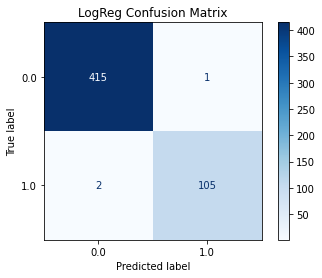

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix


y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues')
plt.title('LogReg Confusion Matrix')

In [36]:
# this could be (../Models/logreg.pkl) because of where this notebook lives
pickle.dump(lr, open('Models/logreg.pkl', 'wb'))

In [37]:
lr_unpickled = pickle.load(open('Models/logreg.pkl', 'rb'))
lr_unpickled

LogisticRegression(max_iter=1000)

In [28]:
import basilica

BASILICA_KEY='b73e93fb-9406-1a2e-1b5a-a67763b69679'
BASILICA = basilica.Connection(BASILICA_KEY)

In [30]:
example_text = BASILICA.embed_sentence('The mars rover just reported new and interesting data!', model='twitter')

In [31]:
lr_unpickled.predict(X_test)

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
lr_unpickled.predict_proba([example_text])

array([[2.86223564e-04, 9.99713776e-01]])